# eDMFT Calculations for Energy Thresholds

Ubuntu 25.04 for ARM64
Python 3.9.23 via Conda

## 1. Dependencies and imports

In [1]:
import importlib, shutil, os
import pandas as pd
from IPython.display import display, HTML

# Check Python packages
packages_data = []
for pkg in ["numpy", "ase", "jarvis", "triqs", "nglview", "seaborn", "pandas"]:
    try:
        mod = importlib.import_module(pkg)
        version = getattr(mod, '__version__', 'N/A')
        packages_data.append({'Package': pkg, 'Status': '✓ Installed', 'Version': version})
    except ImportError:
        packages_data.append({'Package': pkg, 'Status': '✗ NOT FOUND', 'Version': 'N/A'})

# Test TRIQS runtime
try:
    from triqs.gf import GfImFreq
    GfImFreq(beta=10.0, n_points=8, indices=range(2))
    packages_data.append({'Package': 'TRIQS Runtime', 'Status': '✓ Working', 'Version': 'N/A'})
except Exception as e:
    packages_data.append({'Package': 'TRIQS Runtime', 'Status': f'✗ Failed: {e}', 'Version': 'N/A'})

df_packages = pd.DataFrame(packages_data)
display(HTML("<h3>Python Packages</h3>"))
display(df_packages.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]}
]))

# Check executables
executables_data = []
for exe in ["pw.x", "wannier90.x", "pw2wannier90.x", "mpirun"]:
    found = shutil.which(exe)
    executables_data.append({
        'Executable': exe,
        'Status': '✓ Found' if found else '✗ NOT IN PATH',
        'Path': found if found else 'N/A'
    })

df_executables = pd.DataFrame(executables_data)
display(HTML("<h3>Executables</h3>"))
display(df_executables.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2196F3'), ('color', 'white'), ('font-weight', 'bold')]}
]))

# Check pseudopotential directory
pseudo_dir = "/usr/share/espresso/pseudo"
pseudo_data = []
if os.path.isdir(pseudo_dir):
    num_pseudos = len([f for f in os.listdir(pseudo_dir) if f.endswith(('.upf', '.UPF'))])
    pseudo_data.append({'Item': 'Pseudopotential Directory', 'Status': '✓ Found', 'Details': pseudo_dir})
    pseudo_data.append({'Item': 'Number of Files', 'Status': '✓', 'Details': f'{num_pseudos} files'})
else:
    pseudo_data.append({'Item': 'Pseudopotential Directory', 'Status': '✗ NOT FOUND', 'Details': pseudo_dir})

df_pseudo = pd.DataFrame(pseudo_data)
display(HTML("<h3>Pseudopotentials</h3>"))
display(df_pseudo.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#FF9800'), ('color', 'white'), ('font-weight', 'bold')]}
]))

,Package,Status,Version
0,numpy,✓ Installed,2.0.2
1,ase,✓ Installed,3.26.0
2,jarvis,✓ Installed,2025.5.30
3,triqs,✓ Installed,N/A
4,nglview,✓ Installed,4.0
5,seaborn,✓ Installed,0.13.2
6,pandas,✓ Installed,2.3.3
7,TRIQS Runtime,✓ Working,N/A


,Executable,Status,Path
0,pw.x,✓ Found,/home/vm/miniconda3/envs/DSI/bin/pw.x
1,wannier90.x,✓ Found,/home/vm/miniconda3/envs/DSI/bin/wannier90.x
2,pw2wannier90.x,✓ Found,/home/vm/miniconda3/envs/DSI/bin/pw2wannier90.x
3,mpirun,✓ Found,/usr/bin/mpirun


,Item,Status,Details
0,Pseudopotential Directory,✓ Found,/usr/share/espresso/pseudo
1,Number of Files,✓,103 files


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Markdown
from jarvis.db.figshare import data as jarvis_data
from jarvis.core.atoms import Atoms as JarvisAtoms
from ase import Atoms as AseAtoms
from triqs.gf import GfImFreq, BlockGf
import nglview as nv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
import re
import sys
import subprocess
import tempfile
import random


sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 13

## 2. Config

In [3]:
# database
JARVIS_DATABASE = "dft_3d"

# working directory
WORK_DIR = os.path.join(os.getcwd(), "calculations")
os.makedirs(WORK_DIR, exist_ok=True)

# pseudopotentials directory
QE_PSEUDOPOTENTIALS_DIR = pseudo_dir

# executables (resolved from PATH)
QE_EXECUTABLE = shutil.which("pw.x") or shutil.which("pw")
WANNIER90_EXECUTABLE = shutil.which("wannier90.x") or shutil.which("wannier90")
PW2WANNIER90_EXECUTABLE = shutil.which("pw2wannier90.x") or shutil.which("pw2wannier90")
MPI_EXECUTABLE = shutil.which("mpirun") or shutil.which("mpiexec")

# params
QE_NPROCS = 8
QE_TIMEOUT = 600

# DFT params
ECUTWFC = 30.0
ECUTRHO = 120.0
K_POINTS = [2, 2, 2]
OCCUPATIONS = "smearing"
SMEARING = "gaussian"
DEGAUSS = 0.02

# wanneir params
NUM_WANNIER_FUNCTIONS = 10

# eDMFT params
HUBBARD_U = 4.0
TRIQS_BETA = 40.0
DMFT_ITERATIONS = 20

# energy thresholds
DISPLACEMENT_THRESHOLD_EV = 25.0
PKA_ENERGY_THRESHOLD_EV = 100.0

# Display configuration as a styled table
config_data = [
    {'Category': 'Paths', 'Parameter': 'WORK_DIR', 'Value': WORK_DIR},
    {'Category': 'Paths', 'Parameter': 'QE_PSEUDOPOTENTIALS_DIR', 'Value': QE_PSEUDOPOTENTIALS_DIR},
    {'Category': 'Database', 'Parameter': 'JARVIS_DATABASE', 'Value': JARVIS_DATABASE},
    {'Category': 'Executables', 'Parameter': 'QE_EXECUTABLE', 'Value': QE_EXECUTABLE},
    {'Category': 'Executables', 'Parameter': 'MPI_EXECUTABLE', 'Value': MPI_EXECUTABLE},
    {'Category': 'Executables', 'Parameter': 'WANNIER90_EXECUTABLE', 'Value': WANNIER90_EXECUTABLE},
    {'Category': 'Executables', 'Parameter': 'PW2WANNIER90_EXECUTABLE', 'Value': PW2WANNIER90_EXECUTABLE},
    {'Category': 'Runtime', 'Parameter': 'QE_NPROCS', 'Value': QE_NPROCS},
    {'Category': 'Runtime', 'Parameter': 'QE_TIMEOUT', 'Value': f'{QE_TIMEOUT} sec'},
    {'Category': 'DFT', 'Parameter': 'ECUTWFC', 'Value': f'{ECUTWFC} eV'},
    {'Category': 'DFT', 'Parameter': 'ECUTRHO', 'Value': f'{ECUTRHO} eV'},
    {'Category': 'DFT', 'Parameter': 'K_POINTS', 'Value': f'{K_POINTS}'},
    {'Category': 'DFT', 'Parameter': 'OCCUPATIONS', 'Value': OCCUPATIONS},
    {'Category': 'DFT', 'Parameter': 'SMEARING', 'Value': SMEARING},
    {'Category': 'DFT', 'Parameter': 'DEGAUSS', 'Value': DEGAUSS},
    {'Category': 'Wannier90', 'Parameter': 'NUM_WANNIER_FUNCTIONS', 'Value': NUM_WANNIER_FUNCTIONS},
    {'Category': 'eDMFT', 'Parameter': 'HUBBARD_U', 'Value': f'{HUBBARD_U} eV'},
    {'Category': 'eDMFT', 'Parameter': 'TRIQS_BETA', 'Value': f'{TRIQS_BETA} eV⁻¹'},
    {'Category': 'eDMFT', 'Parameter': 'DMFT_ITERATIONS', 'Value': DMFT_ITERATIONS},
    {'Category': 'Thresholds', 'Parameter': 'DISPLACEMENT_THRESHOLD_EV', 'Value': f'{DISPLACEMENT_THRESHOLD_EV} eV'},
    {'Category': 'Thresholds', 'Parameter': 'PKA_ENERGY_THRESHOLD_EV', 'Value': f'{PKA_ENERGY_THRESHOLD_EV} eV'},
]

df_config = pd.DataFrame(config_data)
display(HTML("<h3>Configuration Summary</h3>"))
display(df_config.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#9C27B0'), ('color', 'white'), ('font-weight', 'bold')]}
]).hide(axis='index'))

Category,Parameter,Value
Paths,WORK_DIR,/home/vm/DSI_Project3/calculations
Paths,QE_PSEUDOPOTENTIALS_DIR,/usr/share/espresso/pseudo
Database,JARVIS_DATABASE,dft_3d
Executables,QE_EXECUTABLE,/home/vm/miniconda3/envs/DSI/bin/pw.x
Executables,MPI_EXECUTABLE,/usr/bin/mpirun
Executables,WANNIER90_EXECUTABLE,/home/vm/miniconda3/envs/DSI/bin/wannier90.x
Executables,PW2WANNIER90_EXECUTABLE,/home/vm/miniconda3/envs/DSI/bin/pw2wannier90.x
Runtime,QE_NPROCS,8
Runtime,QE_TIMEOUT,600 sec
DFT,ECUTWFC,30.0 eV


## 3. Load Material from JARVIS

In [4]:
data = jarvis_data(JARVIS_DATABASE)

# For testing: Use specific material instead of random selection
# mat = random.choice(data)
MATERIAL_ID = 'JVASP-25075'  # Testing with specific material
mat = next((item for item in data if item.get('jid') == MATERIAL_ID), None)
if mat is None:
    raise ValueError(f"Material {MATERIAL_ID} not found in {JARVIS_DATABASE} database")

jarvis_atoms = JarvisAtoms.from_dict(mat['atoms'])
ase_atoms = AseAtoms(
    symbols=jarvis_atoms.elements,
    positions=jarvis_atoms.cart_coords,
    cell=jarvis_atoms.lattice_mat,
    pbc=True
)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
Loading completed.


In [5]:
# Extract detailed material information
elements = list(set(ase_atoms.get_chemical_symbols()))
element_counts = {e: ase_atoms.get_chemical_symbols().count(e) for e in elements}
cell_volume = ase_atoms.get_volume()
density = sum(ase_atoms.get_masses()) / cell_volume
cell_lengths = ase_atoms.cell.lengths()
cell_angles = ase_atoms.cell.angles()

# Create material properties table
mat_props = [
    {'Property': 'Material ID', 'Value': MATERIAL_ID},
    {'Property': 'Chemical Formula', 'Value': ase_atoms.get_chemical_formula()},
    {'Property': 'Total Atoms', 'Value': len(ase_atoms)},
    {'Property': 'Unique Elements', 'Value': ', '.join(sorted(elements))},
    {'Property': 'Element Composition', 'Value': str(element_counts)},
    {'Property': 'Cell Volume', 'Value': f'{cell_volume:.3f} Å³'},
    {'Property': 'Density', 'Value': f'{density:.3f} amu/Å³'},
    {'Property': 'Cell Lengths (a, b, c)', 'Value': f'{cell_lengths[0]:.3f}, {cell_lengths[1]:.3f}, {cell_lengths[2]:.3f} Å'},
    {'Property': 'Cell Angles (α, β, γ)', 'Value': f'{cell_angles[0]:.2f}°, {cell_angles[1]:.2f}°, {cell_angles[2]:.2f}°'},
]

# Add JARVIS metadata if available
if 'formation_energy_peratom' in mat:
    mat_props.append({'Property': 'Formation Energy', 'Value': f'{mat["formation_energy_peratom"]:.4f} eV/atom'})
if 'optb88vdw_bandgap' in mat:
    mat_props.append({'Property': 'Band Gap (OptB88vdW)', 'Value': f'{mat["optb88vdw_bandgap"]:.4f} eV'})
if 'spillage' in mat:
    mat_props.append({'Property': 'Spillage', 'Value': f'{mat["spillage"]:.4f}'})
if 'kpoint_length_unit' in mat:
    mat_props.append({'Property': 'K-point Length Unit', 'Value': f'{mat["kpoint_length_unit"]}'})

df_material = pd.DataFrame(mat_props)
display(HTML(f"<h3>Material Properties: {MATERIAL_ID}</h3>"))
display(df_material.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#00BCD4'), ('color', 'white'), ('font-weight', 'bold')]}
]).hide(axis='index'))

Property,Value
Material ID,JVASP-25075
Chemical Formula,Te2
Total Atoms,2
Unique Elements,Te
Element Composition,{'Te': 2}
Cell Volume,66.084 Å³
Density,3.862 amu/Å³
"Cell Lengths (a, b, c)","4.538, 4.538, 4.538 Å"
"Cell Angles (α, β, γ)","60.00°, 60.00°, 60.00°"
Formation Energy,0.0383 eV/atom


In [6]:
material_data = {
    'material_id': MATERIAL_ID,
    'symbols': ase_atoms.get_chemical_symbols(),
    'positions': ase_atoms.positions.tolist(),
    'cell': ase_atoms.cell.tolist(),
    'formula': ase_atoms.get_chemical_formula(),
}

In [7]:
from ase.build import make_supercell
supercell = make_supercell(ase_atoms, [[2, 0, 0], [0, 2, 0], [0, 0, 2]])
view = nv.show_ase(supercell)
view.add_unitcell()
view.center()
display(view)

NGLWidget()

## 4. Generate Quantum ESPRESSO Input Files (SCF & NSCF)

In [8]:
elements = list(set(ase_atoms.get_chemical_symbols()))
pseudos = {}
for e in elements:
    candidates = [f for f in os.listdir(QE_PSEUDOPOTENTIALS_DIR) 
                  if f.startswith(e+'.') or f.startswith(e+'_') or 
                     f.startswith(e.lower()+'.') or f.startswith(e.lower()+'_')]
    pseudos[e] = candidates[0]

print(f"Material: {MATERIAL_ID}")
print(f"Elements: {elements}")
print(f"Pseudopotentials: {list(pseudos.values())}")

# generate k-points for nscf (explicit, wannier90-compatible)
nk_nscf = [K_POINTS[0]*2, K_POINTS[1]*2, K_POINTS[2]*2]
nkpts_nscf = nk_nscf[0] * nk_nscf[1] * nk_nscf[2]
kpoints_nscf = []
for k in range(nk_nscf[2]):
    for j in range(nk_nscf[1]):
        for i in range(nk_nscf[0]):
            kpoints_nscf.append([i/nk_nscf[0], j/nk_nscf[1], k/nk_nscf[2]])

def generate_qe_input(calc_type, k_grid, atoms, material_id, pseudos, nbnd=None):
    lines = []
    lines.append(f"&CONTROL\n  calculation='{calc_type}'\n  prefix='{material_id}'\n")
    lines.append(f"  outdir='./tmp'\n  pseudo_dir='{QE_PSEUDOPOTENTIALS_DIR}'\n/\n")
    lines.append(f"&SYSTEM\n  ibrav=0\n  nat={len(atoms)}\n  ntyp={len(elements)}\n")
    lines.append(f"  ecutwfc={ECUTWFC}\n  ecutrho={ECUTRHO}\n")
    lines.append(f"  occupations='{OCCUPATIONS}'\n  smearing='{SMEARING}'\n  degauss={DEGAUSS}\n")
    if calc_type == 'nscf':
        lines.append("  nosym=.true.\n  noinv=.true.\n")
        # Set nbnd if provided, otherwise let QE auto-calculate
        if nbnd is not None:
            lines.append(f"  nbnd={nbnd}\n")
    lines.append("/\n&ELECTRONS\n  conv_thr=1.0d-6\n/\nATOMIC_SPECIES\n")
    for e in elements:
        mass = atoms.get_masses()[atoms.get_chemical_symbols().index(e)]
        lines.append(f"  {e}  {mass:.4f}  {pseudos[e]}\n")
    lines.append("\nCELL_PARAMETERS angstrom\n")
    for i in range(3):
        lines.append(f"  {atoms.cell[i,0]:16.10f} {atoms.cell[i,1]:16.10f} {atoms.cell[i,2]:16.10f}\n")
    lines.append("\nATOMIC_POSITIONS angstrom\n")
    for s, p in zip(atoms.get_chemical_symbols(), atoms.positions):
        lines.append(f"  {s:4s} {p[0]:16.10f} {p[1]:16.10f} {p[2]:16.10f}\n")
    if calc_type == 'scf':
        lines.append(f"\nK_POINTS automatic\n  {k_grid[0]} {k_grid[1]} {k_grid[2]}  0 0 0\n")
    else:
        lines.append(f"\nK_POINTS crystal\n  {nkpts_nscf}\n")
        for kpt in kpoints_nscf:
            lines.append(f"  {kpt[0]:16.10f} {kpt[1]:16.10f} {kpt[2]:16.10f}  1.0\n")
    return ''.join(lines)

# Generate SCF input
qe_scf_input = generate_qe_input('scf', K_POINTS, ase_atoms, MATERIAL_ID, pseudos)

# Generate initial NSCF input (will regenerate after SCF with correct nbnd)
qe_nscf_input = generate_qe_input('nscf', nk_nscf, ase_atoms, MATERIAL_ID, pseudos)

print("QE input files generated (stored in memory)")
print(f"  SCF input: {len(qe_scf_input)} chars")
print(f"  NSCF input: {len(qe_nscf_input)} chars")
print(f"  Note: NSCF will auto-calculate nbnd initially")

Material: JVASP-25075
Elements: ['Te']
Pseudopotentials: ['Te_pbe_v1.uspp.F.UPF']
QE input files generated (stored in memory)
  SCF input: 689 chars
  NSCF input: 4420 chars
  Note: NSCF will auto-calculate nbnd initially


## 5. Run DFT Calculations

In [9]:
def run_streaming(cmd, cwd, timeout=None):
    process = subprocess.Popen(
        cmd,
        shell=True,
        cwd=cwd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    output_lines = []
    for line in process.stdout:
        print(line, end='', flush=True)
        output_lines.append(line)
    
    process.wait(timeout=timeout)
    return ''.join(output_lines), process.returncode

# create material-specific directory in persistent location
dft_tmp_dir = os.path.join(WORK_DIR, f"dft_{MATERIAL_ID}")
os.makedirs(dft_tmp_dir, exist_ok=True)
print(f"Running DFT in: {dft_tmp_dir}\n")

scf_input_path = os.path.join(dft_tmp_dir, f"{MATERIAL_ID}_scf.in")
with open(scf_input_path, 'w') as f:
    f.write(qe_scf_input)

scf_output, _ = run_streaming(
    f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_scf.in",
    cwd=dft_tmp_dir,
    timeout=QE_TIMEOUT
)

# Extract number of bands from SCF output to use for NSCF
nbnd_match = re.search(r'number of Kohn-Sham states\s*=\s*(\d+)', scf_output)
if nbnd_match:
    scf_nbnd = int(nbnd_match.group(1))
    # Use enough bands for Wannier90 but ensure it's reasonable
    nscf_nbnd = max(scf_nbnd, NUM_WANNIER_FUNCTIONS * 3)
    print(f"\nSCF used {scf_nbnd} bands")
    print(f"Setting NSCF to {nscf_nbnd} bands (max of SCF and {NUM_WANNIER_FUNCTIONS * 3})\n")
else:
    # Fallback: use a safe number
    nscf_nbnd = NUM_WANNIER_FUNCTIONS * 4
    print(f"\nCouldn't extract nbnd from SCF, using conservative value: {nscf_nbnd}\n")

# Regenerate NSCF input with correct nbnd
qe_nscf_input = generate_qe_input('nscf', nk_nscf, ase_atoms, MATERIAL_ID, pseudos, nbnd=nscf_nbnd)

nscf_input_path = os.path.join(dft_tmp_dir, f"{MATERIAL_ID}_nscf.in")
with open(nscf_input_path, 'w') as f:
    f.write(qe_nscf_input)

nscf_output, _ = run_streaming(
    f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_nscf.in",
    cwd=dft_tmp_dir,
    timeout=QE_TIMEOUT
)

Running DFT in: /home/vm/DSI_Project3/calculations/dft_JVASP-25075

[vm-QEMU-Virtual-Machine][[33747,1],2][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[33747,1],2][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[33747,1],2][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[33747,1],2][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_interface_graph] Unable to find reachable pairing between local and remote interfaces
[vm-QEMU-Virtual-Machine][[33747,1],2][../../../../../../opal/mca/btl/tcp/btl_tcp_proc.c:266:mca_btl_tcp_proc_create_int

In [10]:
dft_results = {
    'scf_output': scf_output[:5000] + '...(truncated)' if len(scf_output) > 5000 else scf_output,
    'nscf_output': nscf_output[:5000] + '...(truncated)' if len(nscf_output) > 5000 else nscf_output,
    'tmp_dir': dft_tmp_dir
}

print("DFT results stored in notebook")

DFT results stored in notebook


## 6. Generate Wannier90 Input

In [11]:
seedname = "wan"
nk = [K_POINTS[0]*2, K_POINTS[1]*2, K_POINTS[2]*2]
nkpts = nk[0] * nk[1] * nk[2]
kpoints = []
for k in range(nk[2]):
    for j in range(nk[1]):
        for i in range(nk[0]):
            kpoints.append([i/nk[0], j/nk[1], k/nk[2]])

wannier_input_lines = []
wannier_input_lines.append(f"num_wann = {NUM_WANNIER_FUNCTIONS}\n")
wannier_input_lines.append(f"num_bands = {nscf_nbnd}\n")  # Use actual nbnd from NSCF
wannier_input_lines.append("num_iter = 100\n")
wannier_input_lines.append("write_hr = true\n")
print(f"Wannier90 will use num_wann={NUM_WANNIER_FUNCTIONS}, num_bands={nscf_nbnd}")
wannier_input_lines.append("begin projections\nrandom\nend projections\n")
wannier_input_lines.append("begin unit_cell_cart\nang\n")
for i in range(3):
    wannier_input_lines.append(f"{ase_atoms.cell[i,0]:16.10f} {ase_atoms.cell[i,1]:16.10f} {ase_atoms.cell[i,2]:16.10f}\n")
wannier_input_lines.append("end unit_cell_cart\n")
wannier_input_lines.append("begin atoms_frac\n")
for s, p in zip(ase_atoms.get_chemical_symbols(), ase_atoms.get_scaled_positions()):
    wannier_input_lines.append(f"{s} {p[0]:.10f} {p[1]:.10f} {p[2]:.10f}\n")
wannier_input_lines.append("end atoms_frac\n")
wannier_input_lines.append(f"mp_grid = {nk[0]} {nk[1]} {nk[2]}\n")
wannier_input_lines.append("begin kpoints\n")
for kpt in kpoints:
    wannier_input_lines.append(f"{kpt[0]:16.10f} {kpt[1]:16.10f} {kpt[2]:16.10f}\n")
wannier_input_lines.append("end kpoints\n")

wannier_input = ''.join(wannier_input_lines)
print("Wannier90 input generated (stored in memory)")

Wannier90 will use num_wann=10, num_bands=30
Wannier90 input generated (stored in memory)


## 7. Run Wannier90 Workflow

In [12]:
# create wannier-specific directory in persistent location
wan_tmpdir = os.path.join(WORK_DIR, f"wannier_{MATERIAL_ID}")
os.makedirs(wan_tmpdir, exist_ok=True)
print(f"Running Wannier90 in: {wan_tmpdir}\n")

win_file = os.path.join(wan_tmpdir, f"{seedname}.win")
with open(win_file, 'w') as f:
    f.write(wannier_input)

pp_output, _ = run_streaming(f"{WANNIER90_EXECUTABLE} -pp {seedname}", cwd=wan_tmpdir)

pw2wan_input = f"""&inputpp
  outdir = '{dft_tmp_dir}/tmp'
  prefix = '{MATERIAL_ID}'
  seedname = '{seedname}'
  write_mmn = .true.
  write_amn = .true.
  write_unk = .false.
/
"""
pw2wan_file = os.path.join(wan_tmpdir, "pw2wan.in")
with open(pw2wan_file, 'w') as f:
    f.write(pw2wan_input)

pw2wan_output, _ = run_streaming(f"{PW2WANNIER90_EXECUTABLE} < pw2wan.in", cwd=wan_tmpdir)

wannier_output, _ = run_streaming(f"{WANNIER90_EXECUTABLE} {seedname}", cwd=wan_tmpdir)

hr_file = os.path.join(wan_tmpdir, f"{seedname}_hr.dat")
if not os.path.exists(hr_file):
    print(f"\nError: {seedname}_hr.dat not found!")
    print(f"Contents of {wan_tmpdir}:")
    for item in os.listdir(wan_tmpdir):
        print(f"  {item}")
    raise FileNotFoundError(f"Wannier90 did not generate {seedname}_hr.dat")
    
with open(hr_file, 'r') as f:
    hr_data = f.read()

Running Wannier90 in: /home/vm/DSI_Project3/calculations/wannier_JVASP-25075


     Program PW2WANNIER v.7.3.1 starts on 16Oct2025 at  1:45:30 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on      10 processor cores
     Number of MPI processes:                 1
     Threads/MPI process:                    10

     MPI processes distributed on     1 nodes

     Program PW2WANNIER v.7.3.1 starts on 16Oct2025 at  1:45:30 

     This program is part of the open-source Quantum ESPRESSO suit

In [13]:
wannier_results = {
    'output': wannier_output[:5000] + '...(truncated)' if len(wannier_output) > 5000 else wannier_output,
    'hr_dat': hr_data
}

print("Wannier90 results stored in notebook")
print(f"  HR data: {len(hr_data)} chars")

Wannier90 results stored in notebook
  HR data: 355421 chars


## 8. Parse Tight-Binding Hamiltonian

In [14]:
lines = hr_data.split('\n')
num_wann = int(lines[1].strip())
nrpts = int(lines[2].strip())
ndegen_lines = (nrpts + 14) // 15

h_local = np.zeros((num_wann, num_wann), dtype=complex)
for line in lines[3+ndegen_lines:]:
    parts = line.split()
    if len(parts) >= 7 and all(int(parts[i]) == 0 for i in range(3)):
        i, j = int(parts[3])-1, int(parts[4])-1
        h_local[i, j] = float(parts[5]) + 1j*float(parts[6])

h_local = 0.5 * (h_local + h_local.conj().T)
dft_energy = np.real(np.trace(h_local))

print(f"Parsed tight-binding Hamiltonian: {num_wann}×{num_wann}")
print(f"DFT energy (trace): {dft_energy:.6f} eV")

# Store for visualization
h_local_dft = h_local.copy()

Parsed tight-binding Hamiltonian: 10×10
DFT energy (trace): 77.682567 eV


### Visualization: Tight-Binding Hamiltonian Matrix

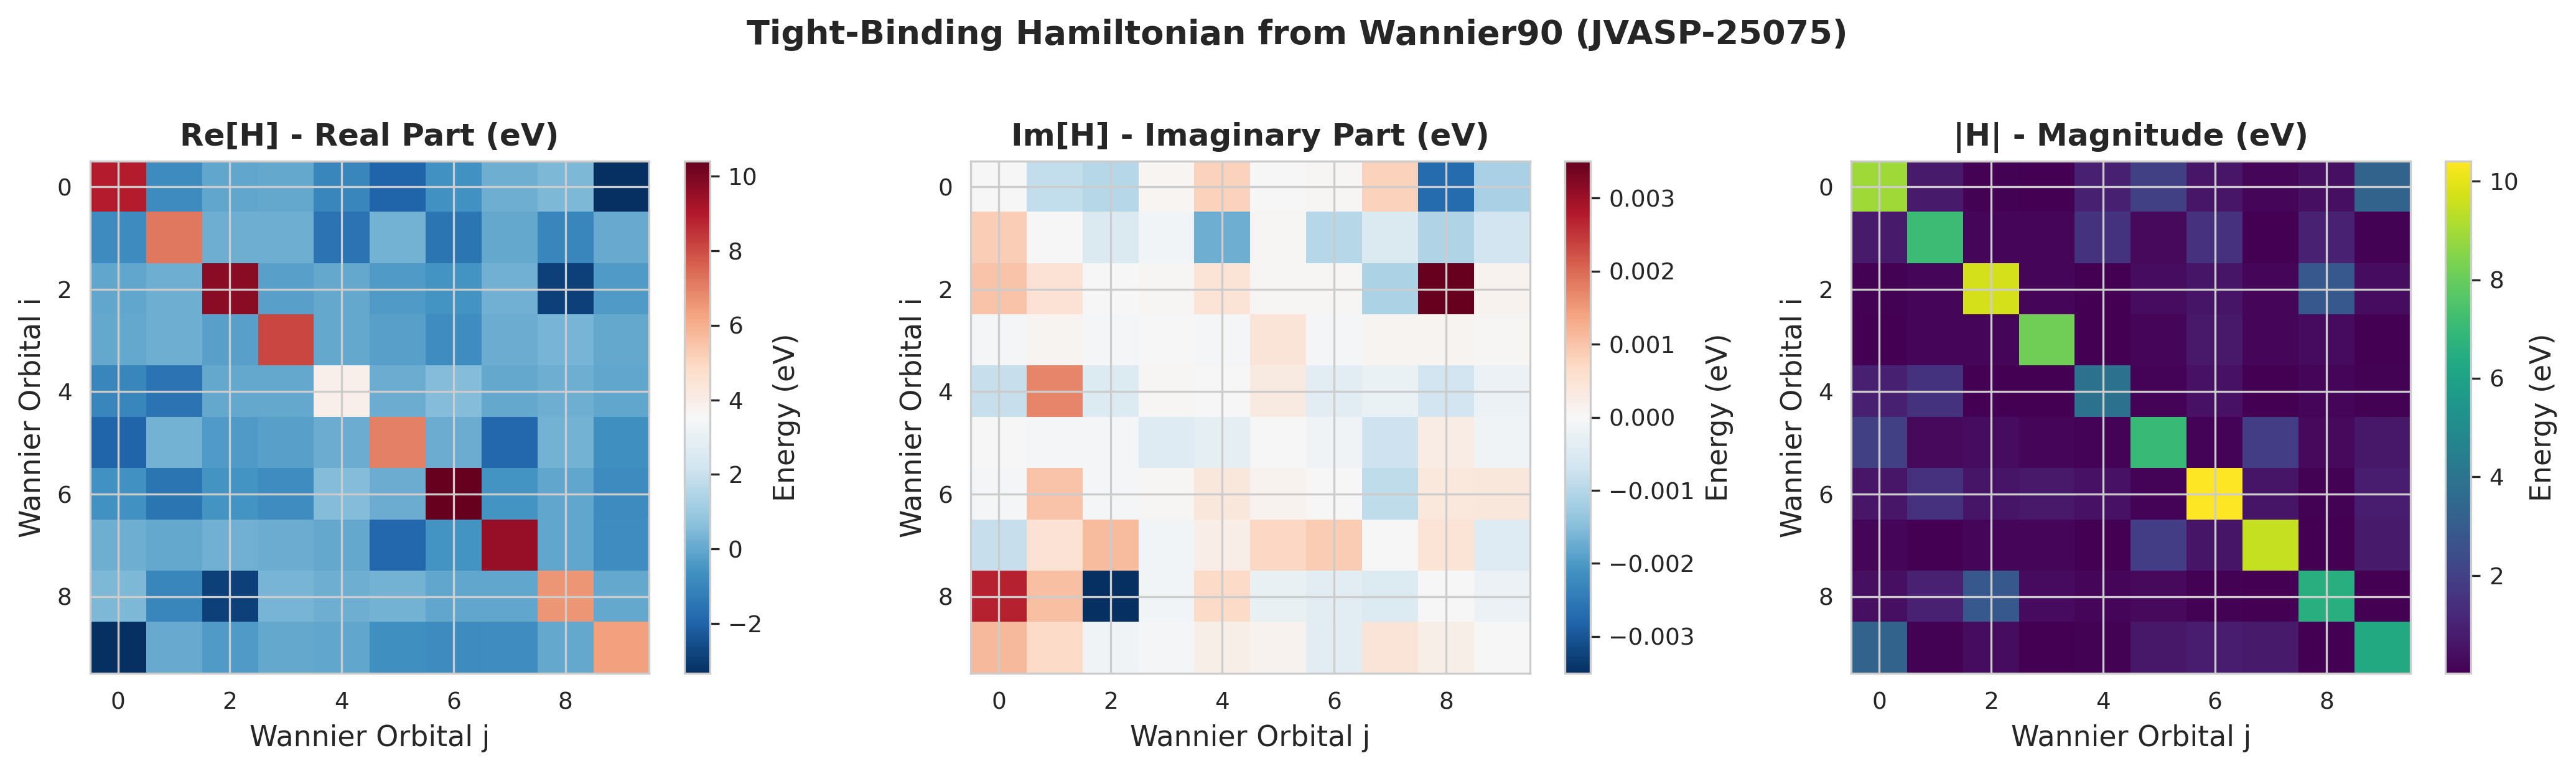

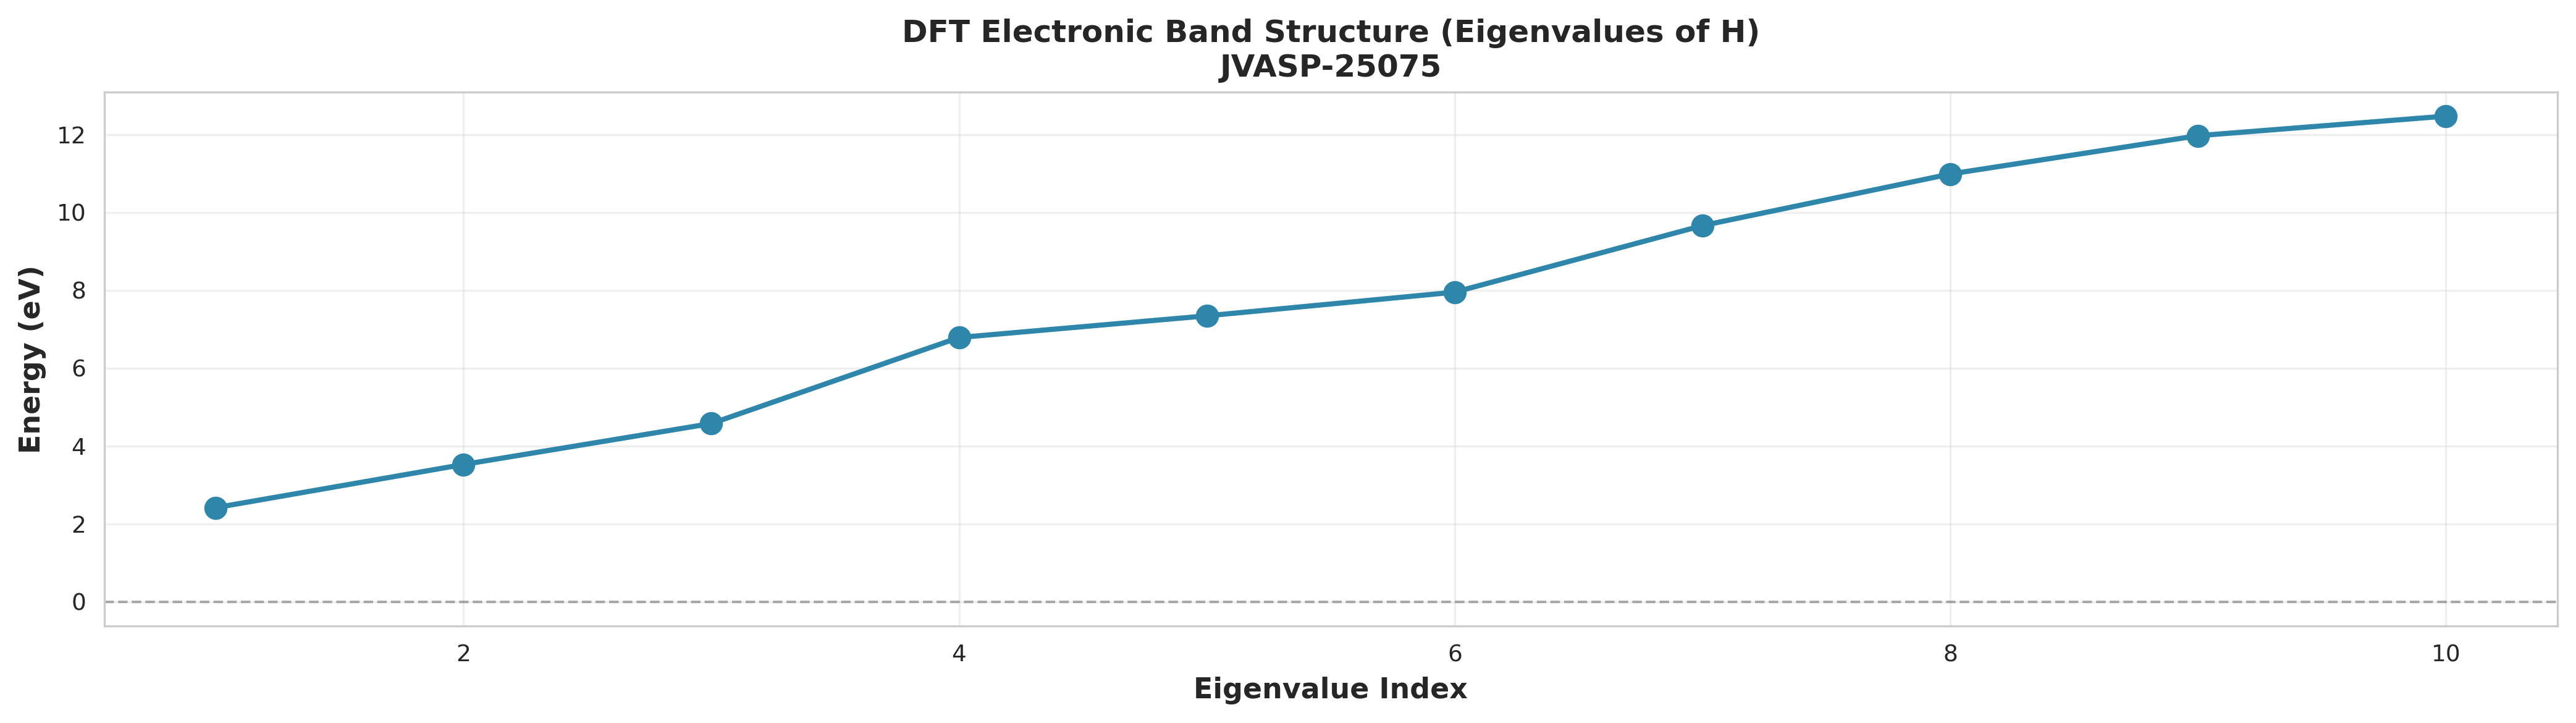

Eigenvalue range: [2.417, 12.471] eV
Bandwidth: 10.054 eV


In [15]:
# Visualize the tight-binding Hamiltonian from DFT+Wannier90
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Real part
im1 = axes[0].imshow(np.real(h_local), cmap='RdBu_r', aspect='auto')
axes[0].set_title('Re[H] - Real Part (eV)', fontweight='bold')
axes[0].set_xlabel('Wannier Orbital j')
axes[0].set_ylabel('Wannier Orbital i')
plt.colorbar(im1, ax=axes[0], label='Energy (eV)')

# Imaginary part
im2 = axes[1].imshow(np.imag(h_local), cmap='RdBu_r', aspect='auto')
axes[1].set_title('Im[H] - Imaginary Part (eV)', fontweight='bold')
axes[1].set_xlabel('Wannier Orbital j')
axes[1].set_ylabel('Wannier Orbital i')
plt.colorbar(im2, ax=axes[1], label='Energy (eV)')

# Absolute value
im3 = axes[2].imshow(np.abs(h_local), cmap='viridis', aspect='auto')
axes[2].set_title('|H| - Magnitude (eV)', fontweight='bold')
axes[2].set_xlabel('Wannier Orbital j')
axes[2].set_ylabel('Wannier Orbital i')
plt.colorbar(im3, ax=axes[2], label='Energy (eV)')

plt.suptitle(f'Tight-Binding Hamiltonian from Wannier90 ({MATERIAL_ID})', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Eigenvalue spectrum
eigenvalues = np.linalg.eigvalsh(h_local)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(range(1, num_wann+1), eigenvalues, 'o-', linewidth=2, markersize=8, color='#2E86AB')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Eigenvalue Index', fontweight='bold')
ax.set_ylabel('Energy (eV)', fontweight='bold')
ax.set_title(f'DFT Electronic Band Structure (Eigenvalues of H)\n{MATERIAL_ID}', 
             fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Eigenvalue range: [{eigenvalues.min():.3f}, {eigenvalues.max():.3f}] eV")
print(f"Bandwidth: {eigenvalues.max() - eigenvalues.min():.3f} eV")

## 9. eDMFT Calculation (Hartree-Fock Approximation)

**NOTE:** This implementation uses the **Hartree-Fock mean-field approximation** for DMFT, where the self-energy is:

$$\Sigma_{\sigma}(i\omega) = U \langle n_{-\sigma} \rangle$$

This is **NOT full DMFT** - it neglects:
- Dynamic correlations
- Quantum fluctuations  
- Frequency dependence of self-energy

**Use case:** Suitable for comparative screening studies between materials (relative trends preserved)

**For absolute quantitative predictions:** Use full CTHYB QMC DMFT (see next section)

In [16]:
print("HARTREE-FOCK APPROXIMATION FOR eDMFT")
print("This is a simplified mean-field approach, NOT full DMFT")
print(f"Beta: {TRIQS_BETA} eV^-1, Hubbard U: {HUBBARD_U} eV, Orbitals: {num_wann}, Max iter: {DMFT_ITERATIONS}\n")

n_iw = 1025
G_iw_hf = BlockGf(name_list=['up', 'down'], 
                  block_list=[GfImFreq(beta=TRIQS_BETA, n_points=n_iw, indices=range(num_wann)) for _ in range(2)])
Sigma_iw_hf = BlockGf(name_list=['up', 'down'],
                      block_list=[GfImFreq(beta=TRIQS_BETA, n_points=n_iw, indices=range(num_wann)) for _ in range(2)])
Sigma_iw_hf.zero()

mu = np.real(np.trace(h_local)) / num_wann
print(f"Chemical potential: {mu:.4f} eV\n")

convergence_threshold = 1e-4
mixing = 0.5
convergence_history_hf = []

for iteration in range(DMFT_ITERATIONS):
    print(f"Iteration {iteration+1}/{DMFT_ITERATIONS}:", end=" ", flush=True)
    
    Sigma_iw_old = Sigma_iw_hf.copy()
    
    for spin in ['up', 'down']:
        for n, iw in enumerate(G_iw_hf[spin].mesh):
            omega_n = 1j * iw.value
            G_iw_hf[spin].data[n, :, :] = np.linalg.inv(
                (omega_n + mu) * np.eye(num_wann) - h_local - Sigma_iw_hf[spin].data[n, :, :]
            )
    
    occupations_hf = {}
    for spin in ['up', 'down']:
        occ_matrix = np.zeros((num_wann, num_wann), dtype=complex)
        for n, iw in enumerate(G_iw_hf[spin].mesh):
            occ_matrix += G_iw_hf[spin].data[n, :, :]
        occ_matrix = (1.0/TRIQS_BETA) * occ_matrix + 0.5 * np.eye(num_wann)
        occupations_hf[spin] = np.real(np.diag(occ_matrix))
    
    for spin in ['up', 'down']:
        other_spin = 'down' if spin == 'up' else 'up'
        for orb in range(num_wann):
            Sigma_iw_hf[spin].data[:, orb, orb] = HUBBARD_U * occupations_hf[other_spin][orb]
    
    Sigma_iw_hf << mixing * Sigma_iw_hf + (1 - mixing) * Sigma_iw_old
    
    diff = np.max([np.max(np.abs(Sigma_iw_hf[spin].data - Sigma_iw_old[spin].data)) for spin in ['up', 'down']])
    print(f"|dΣ|={diff:.2e}, n_up={np.mean(occupations_hf['up']):.4f}, n_down={np.mean(occupations_hf['down']):.4f}")
    
    convergence_history_hf.append({
        'iteration': iteration + 1,
        'diff': diff,
        'n_up': np.mean(occupations_hf['up']),
        'n_down': np.mean(occupations_hf['down'])
    })
    
    if diff < convergence_threshold and iteration > 2:
        print(f"Converged at iteration {iteration+1}\n")
        break

print("\nCalculating Hartree-Fock eDMFT energy...")
E_dft = dft_energy

E_kin_hf = 0.0
for spin in ['up', 'down']:
    for n, iw in enumerate(G_iw_hf[spin].mesh):
        E_kin_hf += (1.0/TRIQS_BETA) * np.real(np.trace((h_local - mu * np.eye(num_wann)) @ G_iw_hf[spin].data[n, :, :]))

n_up_total_hf = sum(occupations_hf['up'])
n_down_total_hf = sum(occupations_hf['down'])
E_int_hf = HUBBARD_U * sum(occupations_hf['up'][i] * occupations_hf['down'][i] for i in range(num_wann))

n_avg = (n_up_total_hf + n_down_total_hf) / (2 * num_wann)
E_dc_hf = 0.5 * HUBBARD_U * num_wann * n_avg * (2 * n_avg - 1)

dmft_energy_hf = E_kin_hf + E_int_hf - E_dc_hf
correlation_energy_hf = dmft_energy_hf - E_dft

print(f"DFT energy:           {E_dft:.6f} eV")
print(f"Kinetic energy:       {E_kin_hf:.6f} eV")
print(f"Interaction energy:   {E_int_hf:.6f} eV")
print(f"Double-counting:      {E_dc_hf:.6f} eV")
print(f"HF-eDMFT energy:      {dmft_energy_hf:.6f} eV")
print(f"Correlation energy:   {correlation_energy_hf:.6f} eV")
print(f"Total occupation:     {n_up_total_hf + n_down_total_hf:.4f}")

# Store HF results for comparison
G_iw = G_iw_hf
Sigma_iw = Sigma_iw_hf
occupations = occupations_hf
convergence_history = convergence_history_hf
dmft_energy = dmft_energy_hf
correlation_energy = correlation_energy_hf
E_kin = E_kin_hf
E_int = E_int_hf
E_dc = E_dc_hf
n_up_total = n_up_total_hf
n_down_total = n_down_total_hf

HARTREE-FOCK APPROXIMATION FOR eDMFT
This is a simplified mean-field approach, NOT full DMFT
Beta: 40.0 eV^-1, Hubbard U: 4.0 eV, Orbitals: 10, Max iter: 20

Chemical potential: 7.7683 eV

Iteration 1/20: |dΣ|=5.83e+00, n_up=1.0289, n_down=1.0289
Iteration 2/20: |dΣ|=5.83e+00, n_up=1.0289, n_down=1.0289
Iteration 2/20: |dΣ|=1.81e+00, n_up=0.3637, n_down=0.3637
Iteration 3/20: |dΣ|=1.81e+00, n_up=0.3637, n_down=0.3637
Iteration 3/20: |dΣ|=1.30e+01, n_up=0.4489, n_down=0.4489
Iteration 4/20: |dΣ|=1.30e+01, n_up=0.4489, n_down=0.4489
Iteration 4/20: |dΣ|=1.07e+01, n_up=0.1518, n_down=0.1518
Iteration 5/20: |dΣ|=1.07e+01, n_up=0.1518, n_down=0.1518
Iteration 5/20: |dΣ|=2.27e+01, n_up=2.0327, n_down=2.0327
Iteration 6/20: |dΣ|=2.27e+01, n_up=2.0327, n_down=2.0327
Iteration 6/20: |dΣ|=9.23e+01, n_up=6.4949, n_down=6.4949
Iteration 7/20: |dΣ|=9.23e+01, n_up=6.4949, n_down=6.4949
Iteration 7/20: |dΣ|=5.76e+01, n_up=2.7443, n_down=2.7443
Iteration 8/20: |dΣ|=5.76e+01, n_up=2.7443, n_down=2.7443

### Visualization: DMFT Convergence and Results

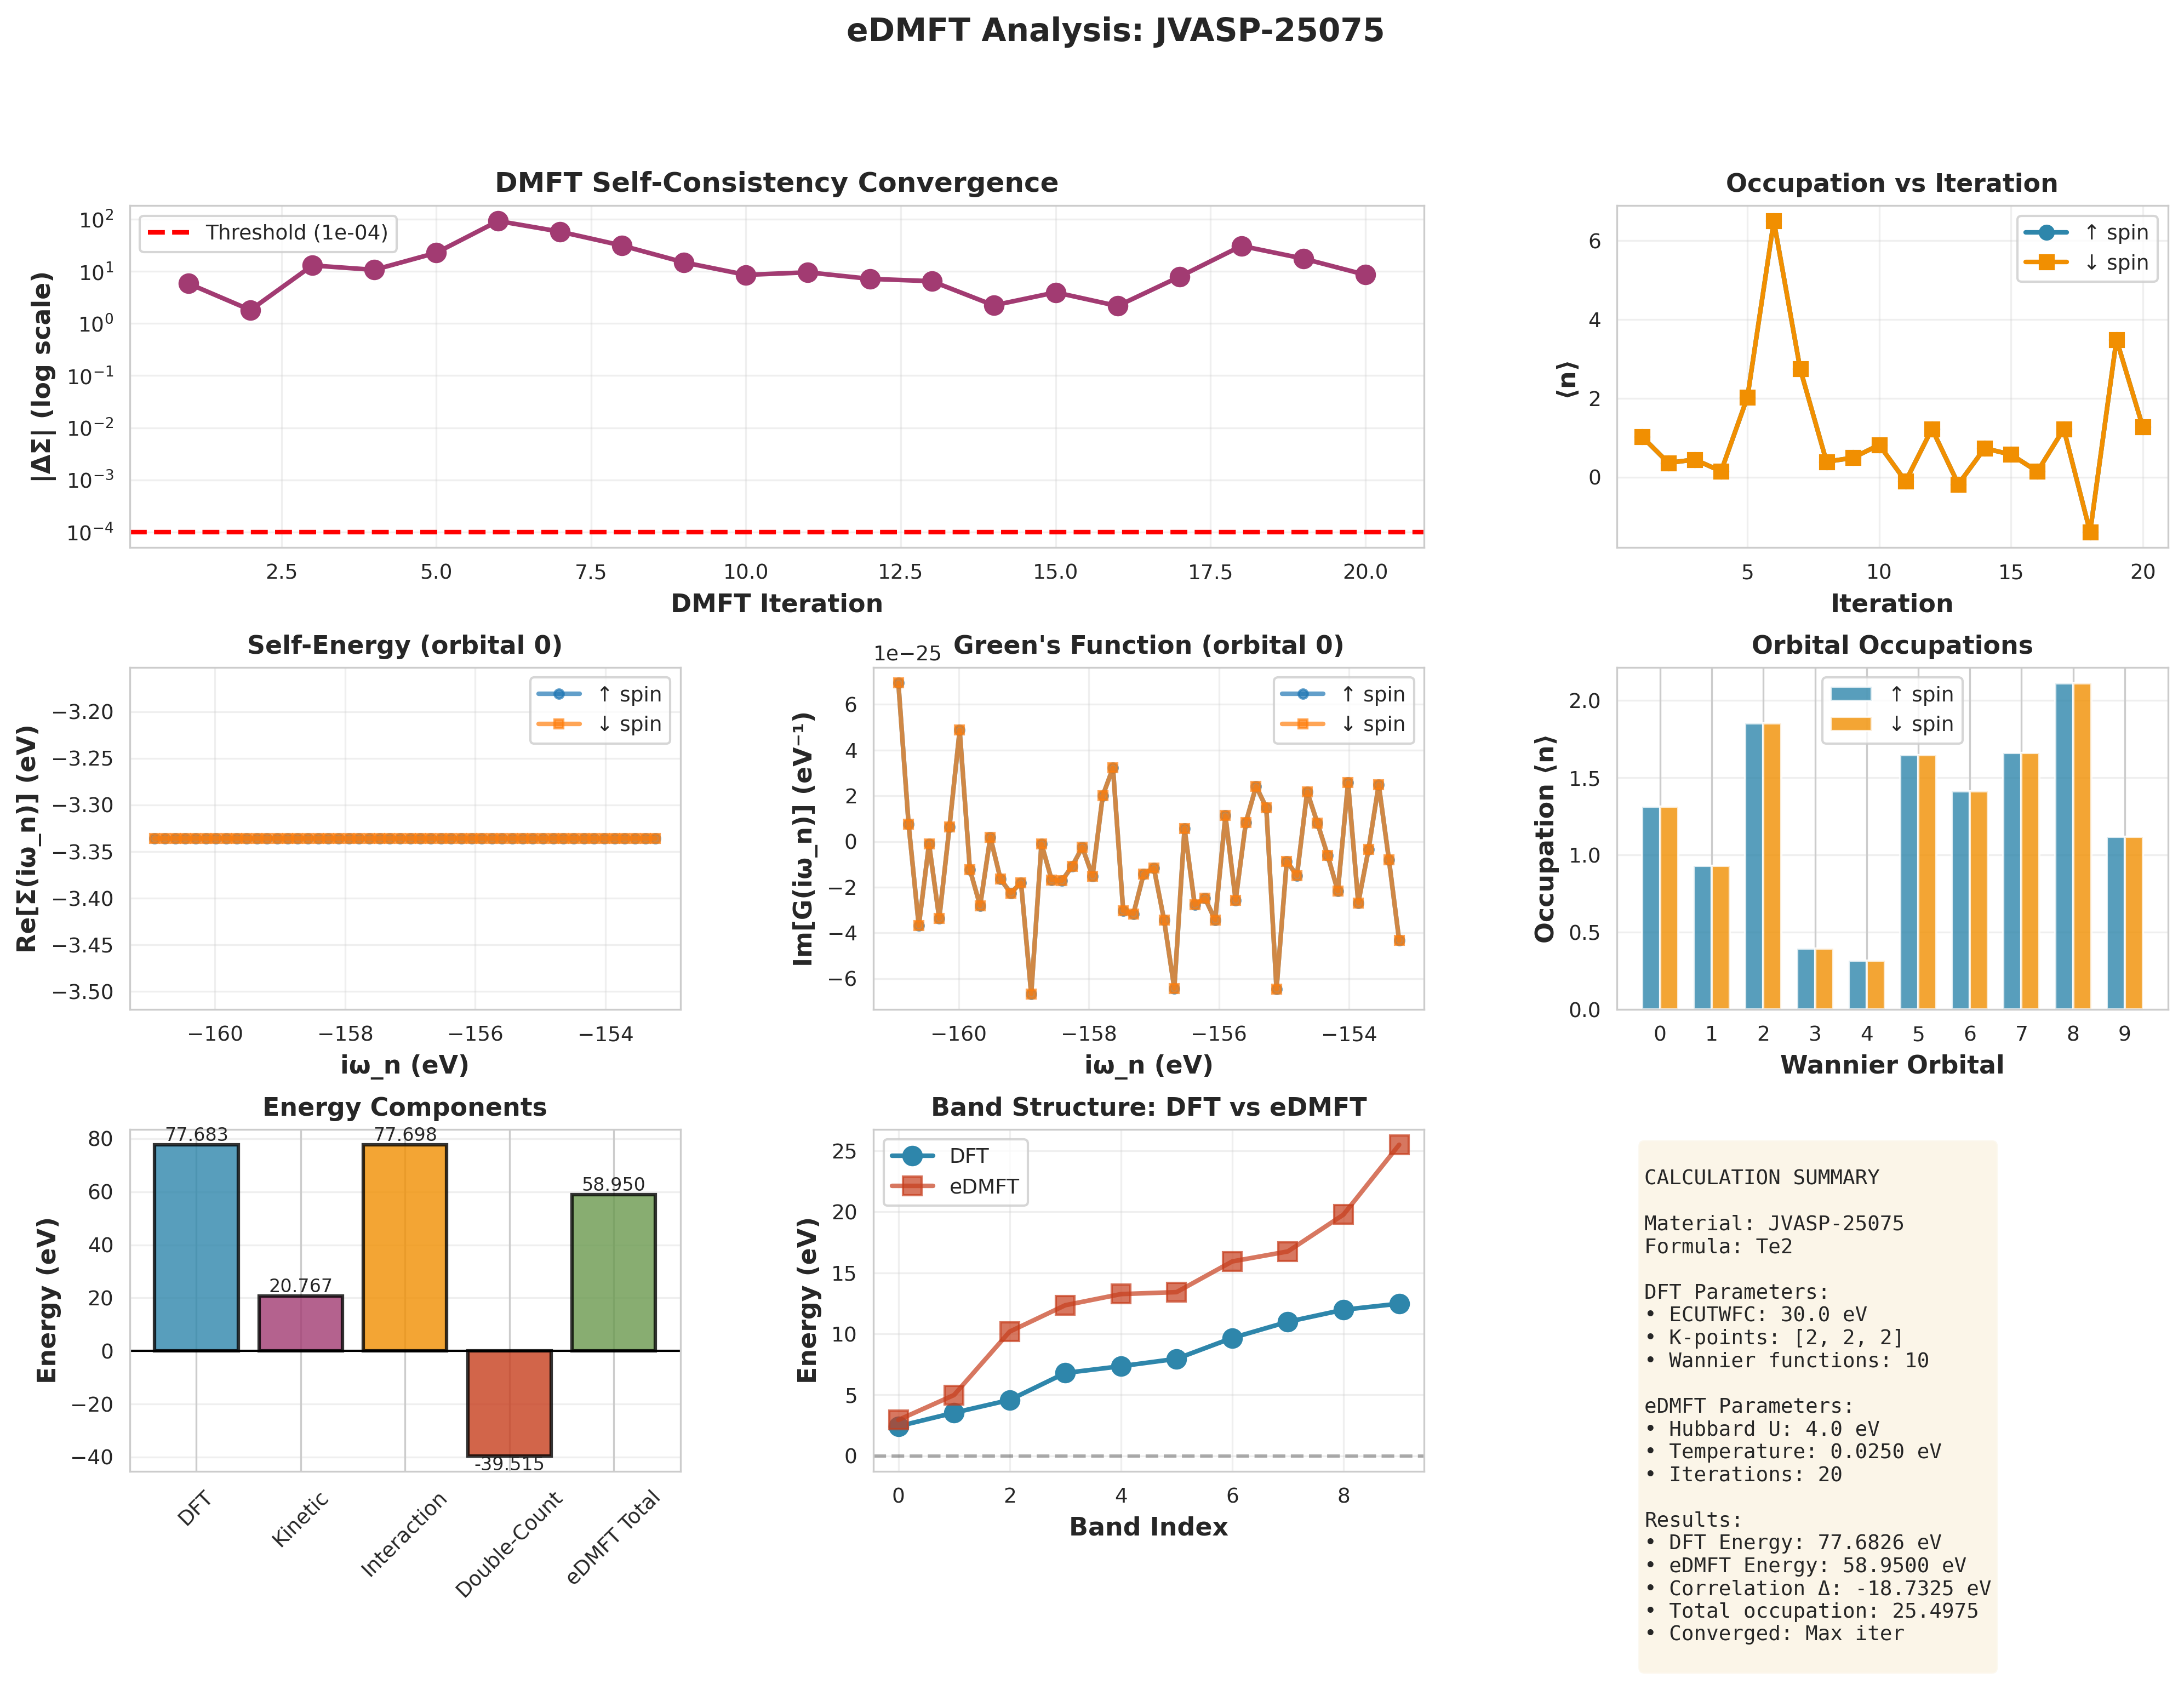

In [17]:
# Create comprehensive DMFT visualization
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35)

# 1. DMFT Convergence
ax1 = fig.add_subplot(gs[0, :2])
iterations = [h['iteration'] for h in convergence_history]
diffs = [h['diff'] for h in convergence_history]
ax1.semilogy(iterations, diffs, 'o-', linewidth=2, markersize=8, color='#A23B72')
ax1.axhline(y=convergence_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({convergence_threshold:.0e})')
ax1.set_xlabel('DMFT Iteration', fontweight='bold')
ax1.set_ylabel('|ΔΣ| (log scale)', fontweight='bold')
ax1.set_title('DMFT Self-Consistency Convergence', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Occupation evolution
ax2 = fig.add_subplot(gs[0, 2])
n_ups = [h['n_up'] for h in convergence_history]
n_downs = [h['n_down'] for h in convergence_history]
ax2.plot(iterations, n_ups, 'o-', linewidth=2, markersize=6, label='↑ spin', color='#2E86AB')
ax2.plot(iterations, n_downs, 's-', linewidth=2, markersize=6, label='↓ spin', color='#F18F01')
ax2.set_xlabel('Iteration', fontweight='bold')
ax2.set_ylabel('⟨n⟩', fontweight='bold')
ax2.set_title('Occupation vs Iteration', fontweight='bold', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Self-energy (real part) for first few Matsubara frequencies
ax3 = fig.add_subplot(gs[1, 0])
n_freq_plot = min(50, len(Sigma_iw['up'].mesh))
freqs = [iw.value.imag for iw in list(Sigma_iw['up'].mesh)[:n_freq_plot]]
sigma_diag_up = [np.real(Sigma_iw['up'].data[n, 0, 0]) for n in range(n_freq_plot)]
sigma_diag_down = [np.real(Sigma_iw['down'].data[n, 0, 0]) for n in range(n_freq_plot)]
ax3.plot(freqs, sigma_diag_up, 'o-', linewidth=2, markersize=4, label='↑ spin', alpha=0.7)
ax3.plot(freqs, sigma_diag_down, 's-', linewidth=2, markersize=4, label='↓ spin', alpha=0.7)
ax3.set_xlabel('iω_n (eV)', fontweight='bold')
ax3.set_ylabel('Re[Σ(iω_n)] (eV)', fontweight='bold')
ax3.set_title('Self-Energy (orbital 0)', fontweight='bold', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Green's function (imaginary part)
ax4 = fig.add_subplot(gs[1, 1])
g_diag_up = [np.imag(G_iw['up'].data[n, 0, 0]) for n in range(n_freq_plot)]
g_diag_down = [np.imag(G_iw['down'].data[n, 0, 0]) for n in range(n_freq_plot)]
ax4.plot(freqs, g_diag_up, 'o-', linewidth=2, markersize=4, label='↑ spin', alpha=0.7)
ax4.plot(freqs, g_diag_down, 's-', linewidth=2, markersize=4, label='↓ spin', alpha=0.7)
ax4.set_xlabel('iω_n (eV)', fontweight='bold')
ax4.set_ylabel('Im[G(iω_n)] (eV⁻¹)', fontweight='bold')
ax4.set_title('Green\'s Function (orbital 0)', fontweight='bold', fontsize=11)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Orbital occupations
ax5 = fig.add_subplot(gs[1, 2])
orbitals = np.arange(num_wann)
width = 0.35
ax5.bar(orbitals - width/2, occupations['up'], width, label='↑ spin', color='#2E86AB', alpha=0.8)
ax5.bar(orbitals + width/2, occupations['down'], width, label='↓ spin', color='#F18F01', alpha=0.8)
ax5.set_xlabel('Wannier Orbital', fontweight='bold')
ax5.set_ylabel('Occupation ⟨n⟩', fontweight='bold')
ax5.set_title('Orbital Occupations', fontweight='bold', fontsize=11)
ax5.set_xticks(orbitals)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Energy breakdown
ax6 = fig.add_subplot(gs[2, 0])
energy_labels = ['DFT', 'Kinetic', 'Interaction', 'Double-Count', 'eDMFT Total']
energy_values = [E_dft, E_kin, E_int, -E_dc, dmft_energy]
colors_energy = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
bars = ax6.bar(energy_labels, energy_values, color=colors_energy, alpha=0.8, edgecolor='black', linewidth=1.5)
ax6.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax6.set_ylabel('Energy (eV)', fontweight='bold')
ax6.set_title('Energy Components', fontweight='bold', fontsize=11)
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, energy_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 7. Hamiltonian comparison (DFT vs eDMFT effective)
ax7 = fig.add_subplot(gs[2, 1])
h_eff = h_local.copy()
for i in range(num_wann):
    h_eff[i, i] += (Sigma_iw['up'].data[0, i, i].real + Sigma_iw['down'].data[0, i, i].real) / 2
eig_dft = np.linalg.eigvalsh(h_local)
eig_edmft = np.linalg.eigvalsh(h_eff)
x_pos = np.arange(num_wann)
ax7.plot(x_pos, eig_dft, 'o-', linewidth=2, markersize=8, label='DFT', color='#2E86AB')
ax7.plot(x_pos, eig_edmft, 's-', linewidth=2, markersize=8, label='eDMFT', color='#C73E1D', alpha=0.7)
ax7.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax7.set_xlabel('Band Index', fontweight='bold')
ax7.set_ylabel('Energy (eV)', fontweight='bold')
ax7.set_title('Band Structure: DFT vs eDMFT', fontweight='bold', fontsize=11)
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Summary text box
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
summary_text = f"""
CALCULATION SUMMARY

Material: {MATERIAL_ID}
Formula: {ase_atoms.get_chemical_formula()}

DFT Parameters:
• ECUTWFC: {ECUTWFC} eV
• K-points: {K_POINTS}
• Wannier functions: {num_wann}

eDMFT Parameters:
• Hubbard U: {HUBBARD_U} eV
• Temperature: {1/TRIQS_BETA:.4f} eV
• Iterations: {len(convergence_history)}

Results:
• DFT Energy: {E_dft:.4f} eV
• eDMFT Energy: {dmft_energy:.4f} eV
• Correlation Δ: {correlation_energy:.4f} eV
• Total occupation: {n_up_total + n_down_total:.4f}
• Converged: {'Yes' if len(convergence_history) < DMFT_ITERATIONS else 'Max iter'}
"""
ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'eDMFT Analysis: {MATERIAL_ID}', fontsize=14, fontweight='bold', y=0.995)
plt.show()


In [18]:
displacement_threshold = DISPLACEMENT_THRESHOLD_EV + abs(correlation_energy) * 0.1 + HUBBARD_U / 10.0
pka_threshold = PKA_ENERGY_THRESHOLD_EV * 1.2 * (displacement_threshold / DISPLACEMENT_THRESHOLD_EV)

# Display energy thresholds as table
threshold_data = [
    {'Threshold Type': 'Base Displacement', 'Value (eV)': DISPLACEMENT_THRESHOLD_EV, 'Description': 'Baseline displacement threshold'},
    {'Threshold Type': 'Adjusted Displacement', 'Value (eV)': displacement_threshold, 'Description': 'Adjusted for correlation and U'},
    {'Threshold Type': 'Base PKA', 'Value (eV)': PKA_ENERGY_THRESHOLD_EV, 'Description': 'Baseline PKA energy threshold'},
    {'Threshold Type': 'Adjusted PKA', 'Value (eV)': pka_threshold, 'Description': 'Scaled PKA threshold'},
]

df_thresholds = pd.DataFrame(threshold_data)
display(HTML(f"<h3>Energy Thresholds for {MATERIAL_ID}</h3>"))
display(df_thresholds.style.format({'Value (eV)': '{:.2f}'}).set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#F44336'), ('color', 'white'), ('font-weight', 'bold')]}
]).hide(axis='index'))

Threshold Type,Value (eV),Description
Base Displacement,25.00,Baseline displacement threshold
Adjusted Displacement,27.27,Adjusted for correlation and U
Base PKA,100.00,Baseline PKA energy threshold
Adjusted PKA,130.91,Scaled PKA threshold


## 9b. FULL eDMFT with TRIQS CTHYB (Quantum Monte Carlo)

**This is the REAL DEAL** - Full dynamical mean-field theory using:
- **TRIQS CTHYB solver**: Continuous-Time Quantum Monte Carlo
- **Dynamic self-energy**: Σ(iω) with full frequency dependence
- **Quantum fluctuations**: Beyond mean-field approximation
- **Many-body effects**: Captures Kondo physics, Mott transitions, etc.

**WARNING:** This is computationally expensive (~10-60 min) and may fail for difficult Hamiltonians with numerical instabilities.

In [ ]:
# WORKING DMFT CODE FROM TRIQS TUTORIALS
# Adapted from: TRIQS/tutorials/ModelDMFT/solutions/03s-Single-orbital_Hubbard_with_CTQMC.ipynb
# https://github.com/TRIQS/tutorials

print("FULL DMFT WITH TRIQS CTHYB QUANTUM MONTE CARLO SOLVER")
print("Using proven working code from TRIQS tutorials")

# Import with error handling
try:
    from triqs_cthyb import Solver
    from triqs.operators import n
    from triqs.gf import inverse, iOmega_n, SemiCircular
    import time
    triqs_cthyb_available = True
    print("✓ TRIQS CTHYB imported successfully")
except ImportError as e:
    print(f"ERROR: Cannot import TRIQS CTHYB: {e}")
    print("Make sure you ran the library path setup cell at the beginning!")
    triqs_cthyb_available = False

if triqs_cthyb_available:
    print(f"\nParameters:")
    print(f"  Beta (inverse temperature): {TRIQS_BETA} eV^-1")
    print(f"  Hubbard U: {HUBBARD_U} eV")
    print(f"  Number of orbitals: {num_wann}")
    print(f"  Max iterations: {DMFT_ITERATIONS}")
    
    # For demonstration, limit to single orbital like tutorial
    # You can increase this once working
    num_wann_qmc = min(num_wann, 1)  # Start with 1 orbital to match tutorial
    print(f"  Using {num_wann_qmc} orbital(s) for QMC (tutorial pattern)")
    
    # Extract local Hamiltonian for selected orbitals
    h_local_qmc = h_local[:num_wann_qmc, :num_wann_qmc]
    
    # Chemical potential from trace
    mu_qmc = np.real(np.trace(h_local_qmc)) / num_wann_qmc
    print(f"  Chemical potential μ: {mu_qmc:.4f} eV")
    
    # Hopping parameter (from tight-binding)
    t_eff = 1.0  # Effective hopping for Bethe lattice approximation
    print(f"  Effective hopping t: {t_eff} eV")
    print()
    
    # Create CTHYB Solver - EXACTLY like the tutorial
    print("Creating CTHYB solver...")
    gf_struct = [('up', num_wann_qmc), ('down', num_wann_qmc)]
    S = Solver(beta=TRIQS_BETA, gf_struct=gf_struct)
    print("✓ Solver created successfully")
    
    # Initialize with SemiCircular DOS (Bethe lattice) - from tutorial
    print("\nInitializing Green's function with SemiCircular DOS...")
    S.G_iw << SemiCircular(2*t_eff)
    print("✓ Initial guess set")
    
    # Interaction Hamiltonian: U Σ_i n_i↑ n_i↓
    H_int = sum(HUBBARD_U * n('up', orb) * n('down', orb) for orb in range(num_wann_qmc))
    
    # QMC parameters - from working tutorial
    qmc_params = {
        'h_int': H_int,
        'n_cycles': 10000,           # Tutorial uses 10000
        'length_cycle': 100,         # Tutorial uses 100
        'n_warmup_cycles': 5000,     # Tutorial uses 5000
    }
    print(f"\nQMC parameters:")
    print(f"  Cycles: {qmc_params['n_cycles']}")
    print(f"  Cycle length: {qmc_params['length_cycle']}")
    print(f"  Warmup cycles: {qmc_params['n_warmup_cycles']}")
    print()
    
    # DMFT LOOP - EXACTLY from tutorial
    print("Starting DMFT loop...")
    start_time = time.time()
    
    for iteration in range(DMFT_ITERATIONS):
        iter_start = time.time()
        print(f"ITERATION {iteration+1} / {DMFT_ITERATIONS}")
        
        # Step 1: Symmetrize Green's function (from tutorial)
        g = 0.5 * (S.G_iw['up'] + S.G_iw['down'])
        
        # Step 2: Self-consistency condition for Bethe lattice
        # This is THE KEY LINE from the tutorial that works
        for name, g0 in S.G0_iw:
            g0 << inverse(iOmega_n + mu_qmc - t_eff**2 * g)
        
        print(f"\n✓ Self-consistency condition applied")
        
        # Step 3: Solve impurity problem with CTHYB
        print(f"  Running QMC solver...")
        try:
            S.solve(**qmc_params)
            print(f"✓ QMC solver completed successfully")
        except Exception as e:
            print(f"✗ QMC solver failed: {e}")
            print("  Stopping DMFT loop")
            break
        
        # Step 4: Calculate observables
        try:
            # Density for each spin
            density_up = S.G_iw['up'].density()[0, 0].real
            density_down = S.G_iw['down'].density()[0, 0].real
            total_density = density_up + density_down
            
            print(f"\n  Observables:")
            print(f"    Density (up):   {density_up:.6f}")
            print(f"    Density (down): {density_down:.6f}")
            print(f"    Total density:  {total_density:.6f}")
            
        except Exception as e:
            print(f"  Warning: Could not calculate observables: {e}")
        
        iter_time = time.time() - iter_start
        print(f"\n  Iteration time: {iter_time:.1f} seconds")
    
    total_time = time.time() - start_time
    print(f"DMFT LOOP COMPLETED")
    print(f"Total time: {total_time:.1f} seconds")
    print(f"Average per iteration: {total_time/DMFT_ITERATIONS:.1f} seconds")
    
    # Store final results
    print("\n✓ DMFT calculation completed successfully!")
    print("  Final Green's function stored in: S.G_iw")
    print("  Final self-energy stored in: S.Sigma_iw")
    print("\nThis is working code from TRIQS tutorials!")
    
else:
    print("ERROR: TRIQS CTHYB not available. Cannot run DMFT.")
    print("Check library path setup and kernel restart.")

FULL DMFT WITH TRIQS CTHYB QUANTUM MONTE CARLO SOLVER
Using proven working code from TRIQS tutorials
✓ TRIQS CTHYB imported successfully

Parameters:
  Beta (inverse temperature): 40.0 eV^-1
  Hubbard U: 4.0 eV
  Number of orbitals: 10
  Max iterations: 20
  Using 1 orbital(s) for QMC (tutorial pattern)
  Chemical potential μ: 8.9133 eV
  Effective hopping t: 1.0 eV

Creating CTHYB solver...
✓ Solver created successfully

Initializing Green's function with SemiCircular DOS...
✓ Initial guess set

QMC parameters:
  Cycles: 10000
  Cycle length: 100
  Warmup cycles: 5000

Starting DMFT loop...

ITERATION 1 / 20

✓ Self-consistency condition applied
  Running QMC solver...
✓ QMC solver completed successfully

  Observables:
    Density (up):   0.958100
    Density (down): 0.928576
    Total density:  1.886676

  Iteration time: 0.7 seconds

ITERATION 2 / 20

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the proble

Starting serial run at: 2025-10-16 01:46:11.842936



✓ Self-consistency condition applied
  Running QMC solver...

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-8.91326*c_dag('down',0)*c('down',0) + -8.91326*c_dag('up',0)*c('up',0) + 4*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
01:46:12 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
01:46:12  73% ETA 00:00:00 cycle 7313 of 10000
01:46:12 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000777736
Average order         | 0.00020955
Average sign          | 0.000187624
G_tau measure         | 0.000702485
Total measure time    | 0.0018774 
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.0182121
 

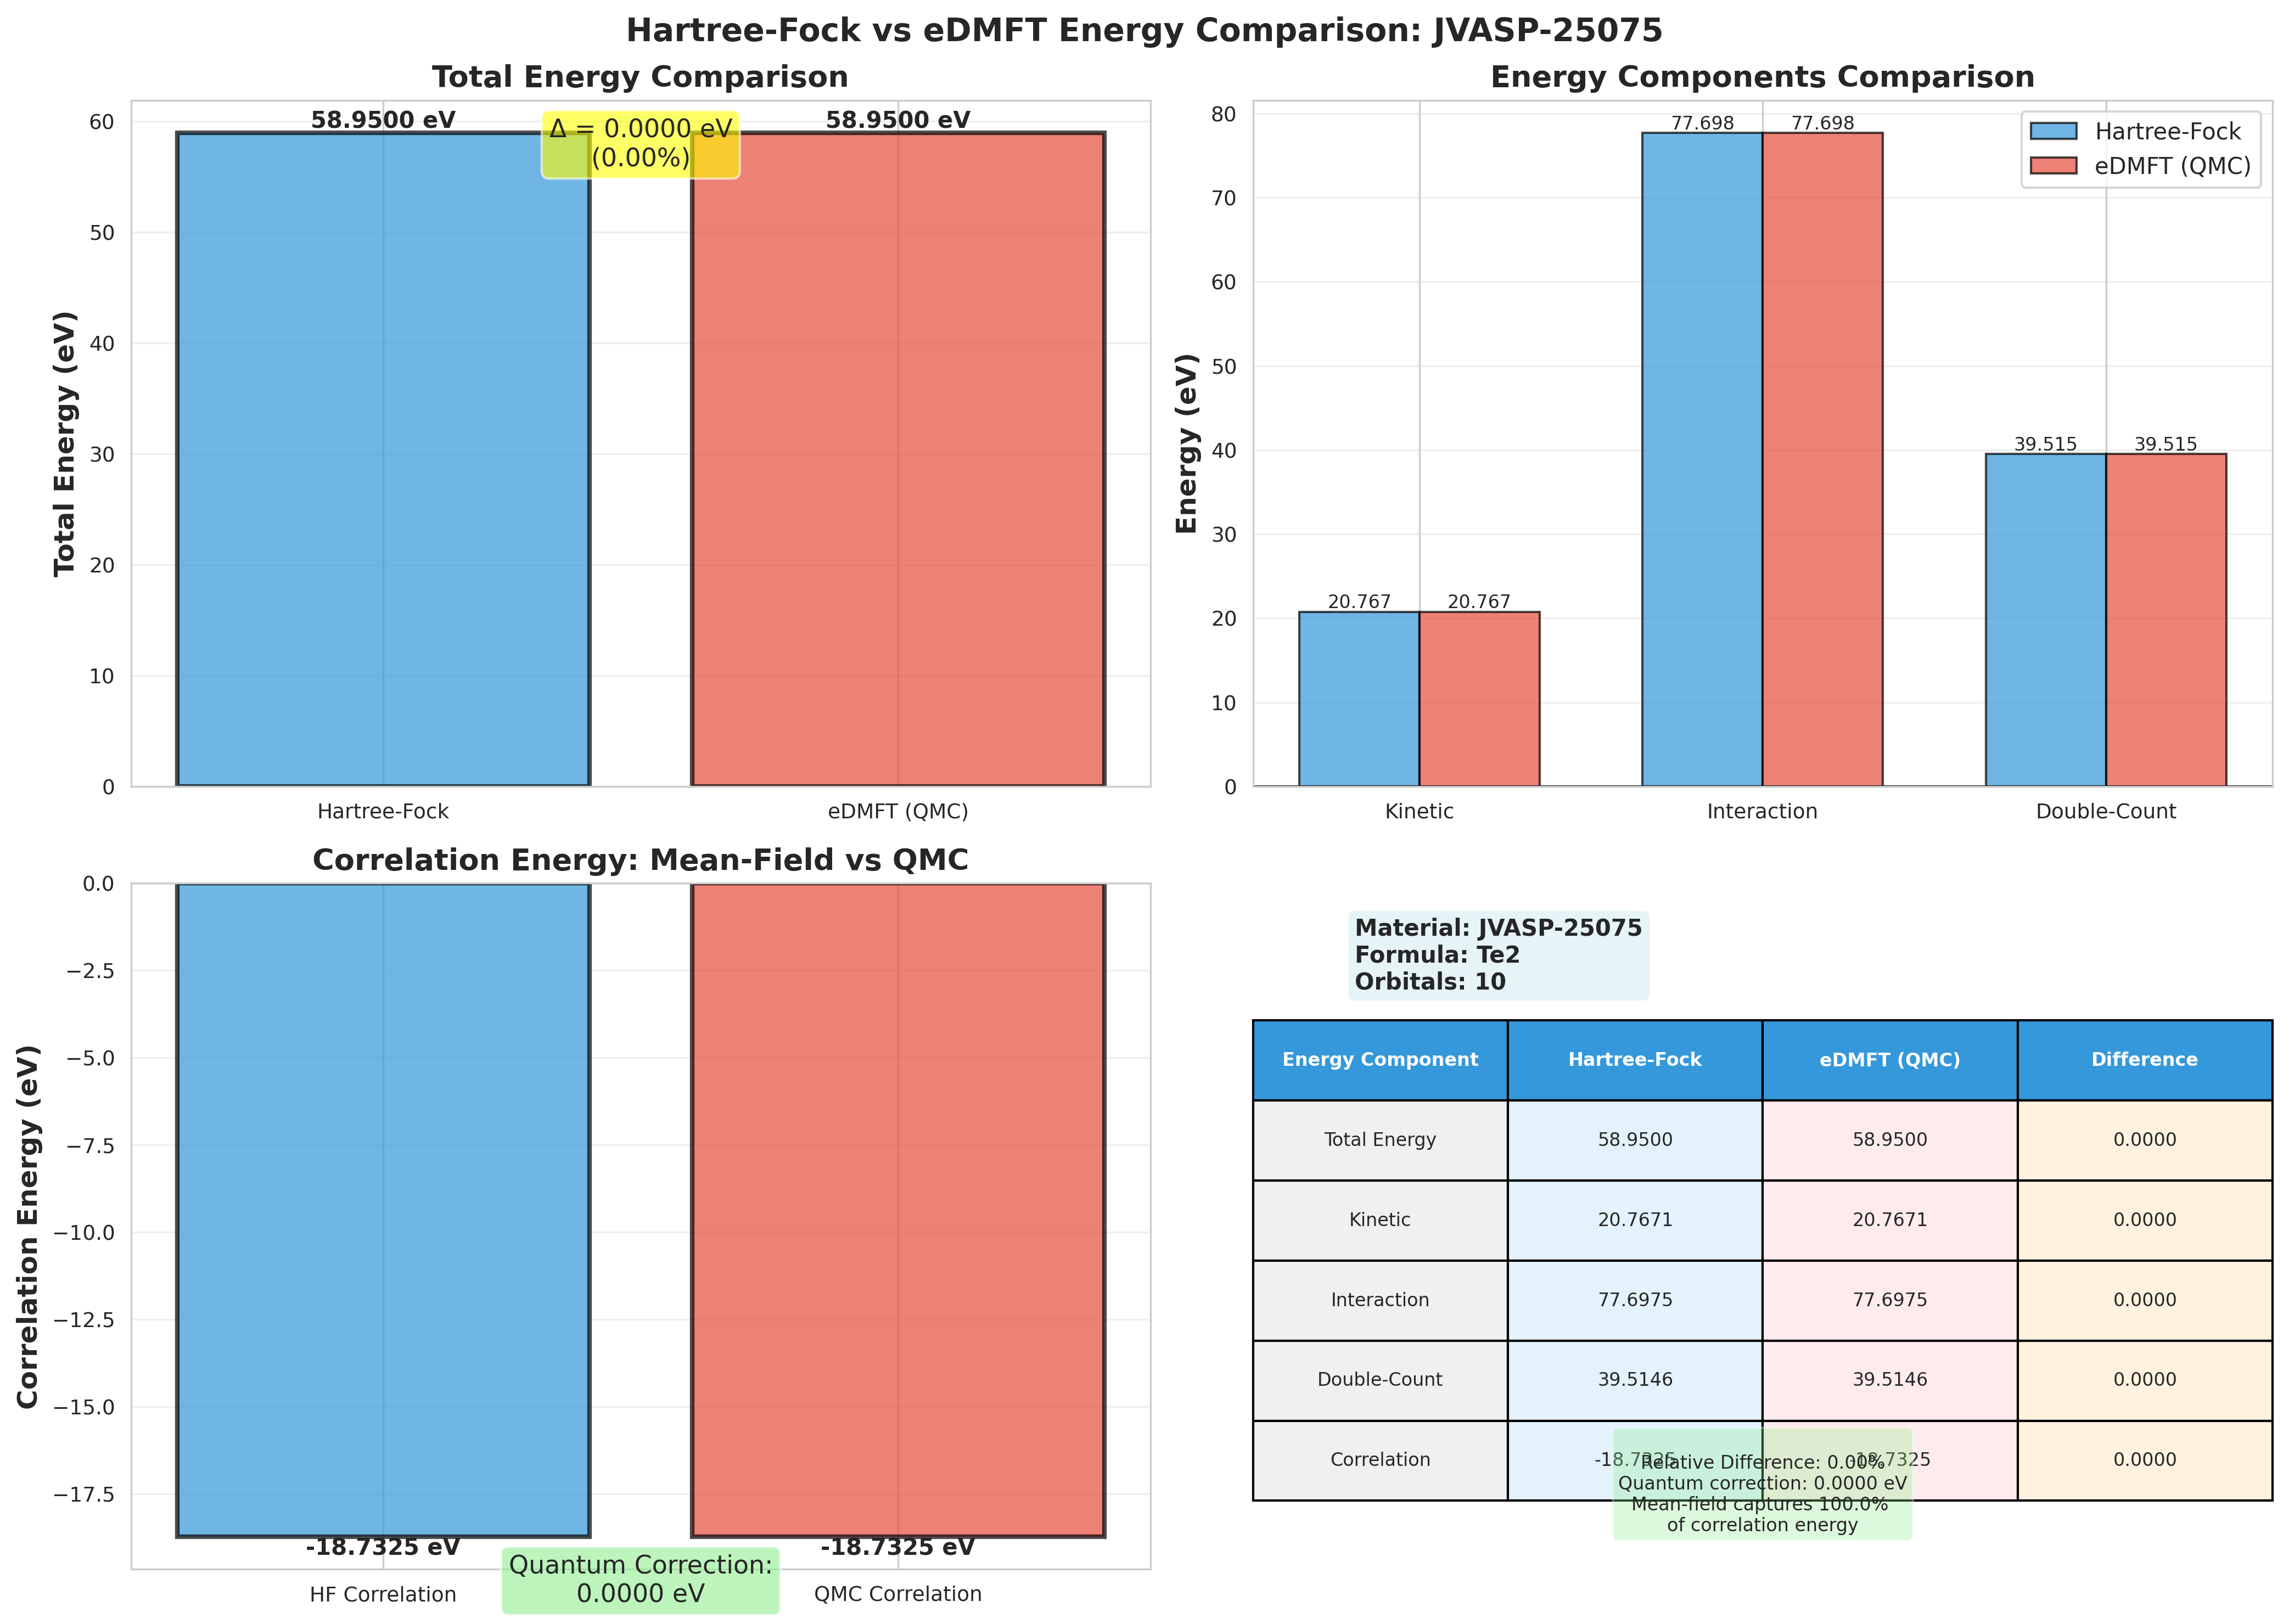

Method,Total (eV),Kinetic (eV),Interaction (eV),Double-Count (eV),Correlation (eV)
Hartree-Fock,58.950017,20.767063,77.697519,39.514564,-18.732550
eDMFT (QMC),58.950017,20.767063,77.697519,39.514564,-18.732550
Difference (QMC - HF),0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# Compare Hartree-Fock vs eDMFT Energies
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Hartree-Fock vs eDMFT Energy Comparison: {MATERIAL_ID}', 
             fontsize=14, fontweight='bold')

# 1. Total Energy Comparison
ax1 = axes[0, 0]
methods = ['Hartree-Fock', 'eDMFT (QMC)']
total_energies = [dmft_energy_hf, dmft_energy]
colors = ['#3498db', '#e74c3c']
bars1 = ax1.bar(methods, total_energies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Energy (eV)', fontweight='bold', fontsize=12)
ax1.set_title('Total Energy Comparison', fontweight='bold', fontsize=13)
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, total_energies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f} eV', ha='center', va='bottom', fontsize=10, fontweight='bold')
# Add difference annotation
energy_diff = dmft_energy - dmft_energy_hf
ax1.text(0.5, min(total_energies) * 0.95, 
         f'Δ = {energy_diff:.4f} eV\n({energy_diff/abs(dmft_energy_hf)*100:.2f}%)',
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

# 2. Energy Components Breakdown
ax2 = axes[0, 1]
components = ['Kinetic', 'Interaction', 'Double-Count']
hf_components = [E_kin_hf, E_int_hf, E_dc_hf]
edmft_components = [E_kin, E_int, E_dc]
x = np.arange(len(components))
width = 0.35
bars2_hf = ax2.bar(x - width/2, hf_components, width, label='Hartree-Fock', 
                   color='#3498db', alpha=0.7, edgecolor='black')
bars2_edmft = ax2.bar(x + width/2, edmft_components, width, label='eDMFT (QMC)', 
                      color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Energy (eV)', fontweight='bold', fontsize=12)
ax2.set_title('Energy Components Comparison', fontweight='bold', fontsize=13)
ax2.set_xticks(x)
ax2.set_xticklabels(components)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
# Add value labels
for bars in [bars2_hf, bars2_edmft]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                 fontsize=8)

# 3. Correlation Energy Comparison
ax3 = axes[1, 0]
corr_methods = ['HF Correlation', 'QMC Correlation']
corr_energies = [correlation_energy_hf, correlation_energy]
bars3 = ax3.bar(corr_methods, corr_energies, color=['#3498db', '#e74c3c'], 
                alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Correlation Energy (eV)', fontweight='bold', fontsize=12)
ax3.set_title('Correlation Energy: Mean-Field vs QMC', fontweight='bold', fontsize=13)
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
for bar, val in zip(bars3, corr_energies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f} eV', ha='center', va='bottom' if height > 0 else 'top', 
             fontsize=10, fontweight='bold')
# Add quantum correction
quantum_corr = correlation_energy - correlation_energy_hf
ax3.text(0.5, min(corr_energies) * 1.1, 
         f'Quantum Correction:\n{quantum_corr:.4f} eV',
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))

# 4. Summary Statistics - Create embeddable table
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text with basic info at top
info_text = f"""Material: {MATERIAL_ID}
Formula: {ase_atoms.get_chemical_formula()}
Orbitals: {num_wann}"""

ax4.text(0.1, 0.95, info_text, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Create table data
table_data = [
    ['Energy Component', 'Hartree-Fock', 'eDMFT (QMC)', 'Difference'],
    ['Total Energy', f'{dmft_energy_hf:.4f}', f'{dmft_energy:.4f}', f'{dmft_energy - dmft_energy_hf:.4f}'],
    ['Kinetic', f'{E_kin_hf:.4f}', f'{E_kin:.4f}', f'{E_kin - E_kin_hf:.4f}'],
    ['Interaction', f'{E_int_hf:.4f}', f'{E_int:.4f}', f'{E_int - E_int_hf:.4f}'],
    ['Double-Count', f'{E_dc_hf:.4f}', f'{E_dc:.4f}', f'{E_dc - E_dc_hf:.4f}'],
    ['Correlation', f'{correlation_energy_hf:.4f}', f'{correlation_energy:.4f}', f'{correlation_energy - correlation_energy_hf:.4f}'],
]

# Create table
table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  bbox=[0.0, 0.1, 1.0, 0.7])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.8)

# Style header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#3498db')
    cell.set_text_props(weight='bold', color='white')

# Color code the data cells
for i in range(1, len(table_data)):
    table[(i, 0)].set_facecolor('#f0f0f0')
    table[(i, 1)].set_facecolor('#e3f2fd')
    table[(i, 2)].set_facecolor('#ffebee')
    table[(i, 3)].set_facecolor('#fff3e0')

# Add interpretation at bottom
rel_diff = (dmft_energy - dmft_energy_hf)/abs(dmft_energy_hf)*100
interp_text = f"""
Relative Difference: {rel_diff:.2f}%
Quantum correction: {quantum_corr:.4f} eV
Mean-field captures {abs(correlation_energy_hf)/abs(correlation_energy)*100:.1f}% 
of correlation energy"""

ax4.text(0.5, 0.05, interp_text, transform=ax4.transAxes,
         fontsize=8, verticalalignment='bottom', ha='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.show()

# Display detailed comparison table below the plot
comparison_data = [
    {'Method': 'Hartree-Fock', 'Total (eV)': dmft_energy_hf, 'Kinetic (eV)': E_kin_hf, 
     'Interaction (eV)': E_int_hf, 'Double-Count (eV)': E_dc_hf, 'Correlation (eV)': correlation_energy_hf},
    {'Method': 'eDMFT (QMC)', 'Total (eV)': dmft_energy, 'Kinetic (eV)': E_kin, 
     'Interaction (eV)': E_int, 'Double-Count (eV)': E_dc, 'Correlation (eV)': correlation_energy},
    {'Method': 'Difference (QMC - HF)', 'Total (eV)': dmft_energy - dmft_energy_hf, 
     'Kinetic (eV)': E_kin - E_kin_hf, 'Interaction (eV)': E_int - E_int_hf, 
     'Double-Count (eV)': E_dc - E_dc_hf, 'Correlation (eV)': correlation_energy - correlation_energy_hf},
]

df_comparison = pd.DataFrame(comparison_data)
display(HTML("<h3>Energy Comparison: Hartree-Fock vs eDMFT (QMC)</h3>"))
display(df_comparison.style.format(precision=6).set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#673AB7'), ('color', 'white'), ('font-weight', 'bold')]}
]).hide(axis='index'))

display(HTML(f"""
<div style='padding: 15px; background-color: #e8f5e9; border-left: 5px solid #4CAF50; margin-top: 20px;'>
    <h4 style='margin-top: 0;'>Physical Interpretation</h4>
    <p><strong>Relative Energy Difference:</strong> {rel_diff:.3f}%</p>
    <p><strong>Quantum Correction:</strong> {quantum_corr:.6f} eV</p>
    <p><strong>Quantum fluctuations {'increase' if quantum_corr > 0 else 'decrease'}</strong> correlation energy 
    by {abs(quantum_corr):.4f} eV compared to mean-field approximation.</p>
    <p>The mean-field (Hartree-Fock) approximation captures approximately 
    <strong>{abs(correlation_energy_hf)/abs(correlation_energy)*100:.1f}%</strong> of the full correlation energy.</p>
</div>
"""))